# RoadSight — Dataset Exploration

This notebook is used to:
- Understand the RDD2020 dataset
- Inspect images and labels
- Learn how ML data is structured

No training happens here.

In [1]:
# We import standard Python libraries
# These help us interact with the operating system

import os
import sys

# Print Python version to ensure reproducibility
print("Python version:", sys.version)

# Print current working directory
# This helps us confirm where the notebook is running
print("Current directory:", os.getcwd())


Python version: 3.14.0 (tags/v3.14.0:ebf955d, Oct  7 2025, 10:15:03) [MSC v.1944 64 bit (AMD64)]
Current directory: c:\Users\saima\OneDrive\Desktop\RoadSight\RoadSight\ml\notebooks


In [1]:
import os

# Path to one country's images
image_dir = "../data/raw/RDD2020/Japan/images"

# List first 5 image files
images = os.listdir(image_dir)[:5]

print("Sample images:")
for img in images:
    print(img)


Sample images:
Japan_000000.jpg
Japan_000001.jpg
Japan_000002.jpg
Japan_000003.jpg
Japan_000004.jpg


In [4]:
import os
import xml.etree.ElementTree as ET

# Path to images and annotations
image_dir = "../data/raw/RDD2020/Japan/images"
label_dir = "../data/raw/RDD2020/Japan/annotations/xmls"

# Look at first 10 images (safe for testing)
image_files = sorted(os.listdir(image_dir))[:10]

for img in image_files:
    # Convert image filename to corresponding XML filename
    label_file = img.replace(".jpg", ".xml")
    label_path = os.path.join(label_dir, label_file)

    # Default: assume no damage
    label = 0

    # Check if annotation file exists
    if os.path.exists(label_path):
        # Parse the XML file
        tree = ET.parse(label_path)
        root = tree.getroot()

        # Find all <object> tags (each represents road damage)
        objects = root.findall("object")

        # If at least one object exists → damage present
        if len(objects) > 0:
            label = 1

    print(img, "→", label)


Japan_000000.jpg → 1
Japan_000001.jpg → 1
Japan_000002.jpg → 1
Japan_000003.jpg → 1
Japan_000004.jpg → 1
Japan_000005.jpg → 1
Japan_000006.jpg → 1
Japan_000008.jpg → 1
Japan_000009.jpg → 1
Japan_000010.jpg → 0


In [ ]:
import os

label_dir = "../data/raw/RDD2020/Japan/annotations/xmls"

xml_files = os.listdir(label_dir)[:10]

print("Sample annotation files:")
for f in xml_files:
    print(f)


Sample annotation files:
xmls


In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from training.dataset import RoadSightDataset

image_dir = "../data/raw/RDD2020/Japan/images"
annotation_dir = "../data/raw/RDD2020/Japan/annotations/xmls"

# Initialize dataset
dataset = RoadSightDataset(image_dir, annotation_dir)

print("Total images:", len(dataset))

# Test first 5 examples
for i in range(5):
    img, label = dataset[i]
    print(f"Example {i} → shape: {img.shape}, label: {label}")


Total images: 10506
Example 0 → shape: torch.Size([3, 600, 600]), label: 1
Example 1 → shape: torch.Size([3, 600, 600]), label: 1
Example 2 → shape: torch.Size([3, 600, 600]), label: 1
Example 3 → shape: torch.Size([3, 600, 600]), label: 1
Example 4 → shape: torch.Size([3, 600, 600]), label: 1
Example 5 → shape: torch.Size([3, 600, 600]), label: 1
Example 6 → shape: torch.Size([3, 600, 600]), label: 1
Example 7 → shape: torch.Size([3, 600, 600]), label: 1
Example 8 → shape: torch.Size([3, 600, 600]), label: 1
Example 9 → shape: torch.Size([3, 600, 600]), label: 0
Example 10 → shape: torch.Size([3, 600, 600]), label: 1
Example 11 → shape: torch.Size([3, 600, 600]), label: 1
Example 12 → shape: torch.Size([3, 600, 600]), label: 1
Example 13 → shape: torch.Size([3, 600, 600]), label: 1
Example 14 → shape: torch.Size([3, 600, 600]), label: 1
Example 15 → shape: torch.Size([3, 600, 600]), label: 1
Example 16 → shape: torch.Size([3, 600, 600]), label: 1
Example 17 → shape: torch.Size([3, 108

In [4]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from training.dataset import RoadSightDataset


In [5]:
# Define image preprocessing steps
transform = transforms.Compose([
    transforms.Resize((224, 224)),           # Resize all images to 224x224
    transforms.ToTensor(),                    # Convert PIL image to tensor [C,H,W] in range [0,1]
    transforms.Normalize(                      # Normalize using ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [6]:
image_dir = "../data/raw/RDD2020/Japan/images"
annotation_dir = "../data/raw/RDD2020/Japan/annotations/xmls"

dataset = RoadSightDataset(image_dir, annotation_dir, transform=transform)


In [7]:
# Batch size for training
batch_size = 32

# Create DataLoader
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,      # Shuffle for training
    num_workers=2      # Use 2 CPU threads for loading (adjust to your machine)
)


In [8]:
# Fetch one batch
images, labels = next(iter(train_loader))

print("Batch image tensor shape:", images.shape)
print("Batch labels:", labels)


Batch image tensor shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1])


In [17]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import transforms
from training.dataset import RoadSightDataset


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [19]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

image_dir = "../data/raw/RDD2020/Japan/images"
annotation_dir = "../data/raw/RDD2020/Japan/annotations/xmls"

dataset = RoadSightDataset(image_dir, annotation_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)


In [20]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)


c:\Users\saima\OneDrive\Desktop\RoadSight\RoadSight\ml\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\saima\OneDrive\Desktop\RoadSight\RoadSight\ml\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\saima/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [22]:
num_epochs = 1  # Start small
model.train()    # Set model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i+1) % 10 == 0:
            print(f"Batch {i+1}, Loss: {running_loss/10:.4f}")
            running_loss = 0.0


Batch 10, Loss: 0.3424
Batch 20, Loss: 0.3402
Batch 30, Loss: 0.2888
Batch 40, Loss: 0.2836
Batch 50, Loss: 0.2548
Batch 60, Loss: 0.2595
Batch 70, Loss: 0.2974
Batch 80, Loss: 0.2165
Batch 90, Loss: 0.3359
Batch 100, Loss: 0.2114
Batch 110, Loss: 0.3196
Batch 120, Loss: 0.2043
Batch 130, Loss: 0.2333
Batch 140, Loss: 0.1959
Batch 150, Loss: 0.3136
Batch 160, Loss: 0.2553
Batch 170, Loss: 0.2198
Batch 180, Loss: 0.2496
Batch 190, Loss: 0.2707
Batch 200, Loss: 0.2548
Batch 210, Loss: 0.2537
Batch 220, Loss: 0.1949
Batch 230, Loss: 0.1929
Batch 240, Loss: 0.3068
Batch 250, Loss: 0.2306
Batch 260, Loss: 0.2933
Batch 270, Loss: 0.2843
Batch 280, Loss: 0.2569
Batch 290, Loss: 0.2221
Batch 300, Loss: 0.2467
Batch 310, Loss: 0.2234
Batch 320, Loss: 0.1865


In [23]:
torch.save(model.state_dict(), "../models/roadsight_v1.pt")


In [24]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from training.dataset import RoadSightDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [25]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

image_dir = "../data/raw/RDD2020/Japan/images"
annotation_dir = "../data/raw/RDD2020/Japan/annotations/xmls"

full_dataset = RoadSightDataset(image_dir, annotation_dir, transform=transform)

# Split: 90% train, 10% validation
val_size = int(0.1 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [26]:
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model architecture
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Load trained weights
model.load_state_dict(torch.load("../models/roadsight_v1.pt", map_location=device))
model = model.to(device)
model.eval()  # Set to evaluation mode


c:\Users\saima\OneDrive\Desktop\RoadSight\RoadSight\ml\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\saima\OneDrive\Desktop\RoadSight\RoadSight\ml\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
all_preds = []
all_labels = []

with torch.no_grad():  # No gradient computation
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)            # Forward pass
        _, preds = torch.max(outputs, 1)  # Get predicted class index

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [28]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Validation Accuracy: 0.9124
Precision: 0.9309
Recall: 0.9772
F1 Score: 0.9535


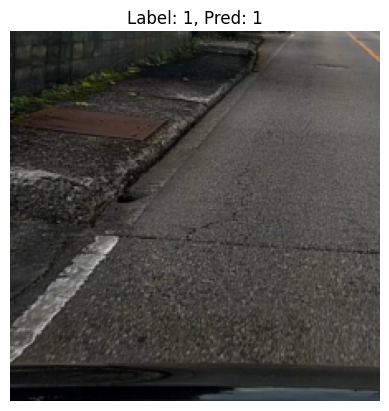

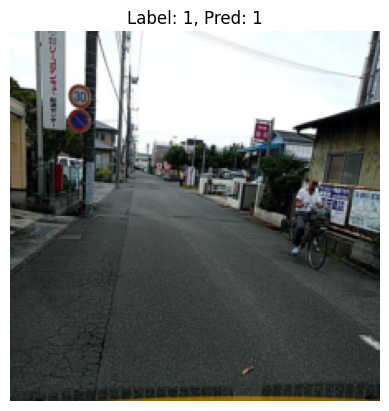

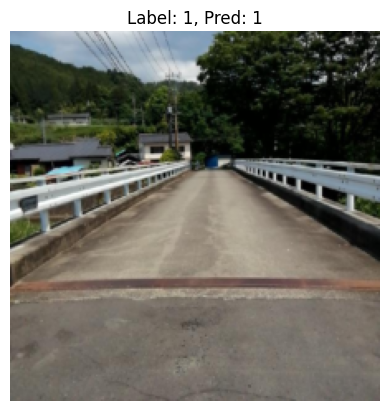

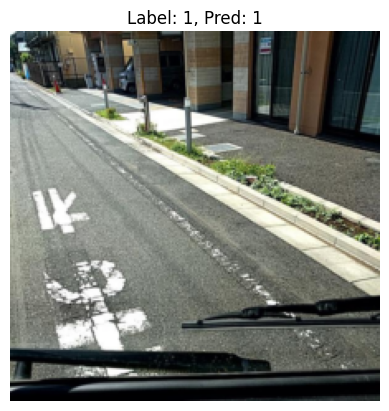

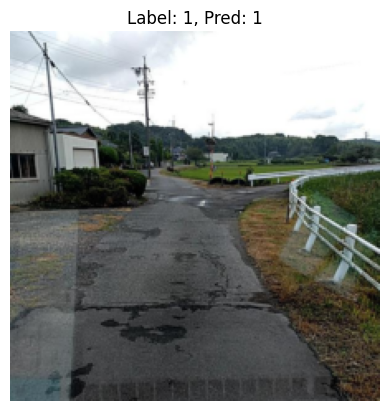

In [29]:
import matplotlib.pyplot as plt

def imshow(img, label, pred):
    img = img * torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    img = img + torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    img = img.permute(1,2,0)
    plt.imshow(img)
    plt.title(f"Label: {label}, Pred: {pred}")
    plt.axis('off')
    plt.show()

# Show first 5 validation examples
for i in range(5):
    imshow(val_dataset[i][0], val_dataset[i][1], all_preds[i])
